# Italy GDP by region (2023)

In [1]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from mpl_ornaments.titles import set_title_and_subtitle

## Get the data

### Get the geographical data

Use [`geopandas.read_file`](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html) to retrieve the geographical data. Keep only the `reg_name` (region name) and `geometry` (region boundaries) columns.

In [2]:
df_gdata = gpd.read_file('https://raw.githubusercontent.com/bianconif/graphic_communication_notebooks/refs/heads/master/data/geo/georef-italy-regione-millesime.shp')
df_gdata = df_gdata[['reg_name', 'geometry']]
print(df_gdata.head())

        reg_name                                           geometry
0  Valle d'Aosta  POLYGON ((7.86405 45.91644, 7.8619 45.91443, 7...
1        Toscana  MULTIPOLYGON (((11.10968 42.26361, 11.11109 42...
2         Molise  POLYGON ((15.13805 41.92665, 15.13614 41.9246,...
3     Basilicata  MULTIPOLYGON (((16.6357 40.75851, 16.63708 40....
4         Puglia  MULTIPOLYGON (((17.96784 40.65964, 17.96977 40...


Observe that the geographical data are stored using vector GIS primitives like _polygons_ (`POLYGON`) and _multi-polygons_ (`MULTIPOLYGON`). In short a polygon is a geometric object that can have one or more _rings_, where rings are collections of _points_ forming closed, non-intersecting loops. Multi-polygons are collections or two or more disjoint polygons. Hence polygons are used to represent the boundaries of connected geographical units , with or without holes (such as regions composed of a single piece of land or an island); multi-polygons to represent non-connected geographical units, as are for instance those containing portions of land that are separated from the mainland (such as islands or exclaves). Finally, points are geometric elements defined by their _x_ and _y_ coordinates, usually expressed in degrees of longitude and latitude, respectively.   

### Get the GDP data

In [3]:
df_gdp = pd.read_csv('https://raw.githubusercontent.com/bianconif/graphic_communication_notebooks/refs/heads/master/data/istat/italy-gdp-by-region.csv', comment='#')
print(df_gdp.head())

                               Region  2021  2022  2023
0                            Piemonte  32.3  34.5  36.7
1                       Valle d'Aosta  38.7  43.9  46.3
2                           Lombardia  42.6  46.0  49.1
3  Provincia Autonoma Bolzano / Bozen  49.9  56.0  59.8
4           Provincia Autonoma Trento  39.5  43.9  46.4


### Merge the GDP and geographical data

Merge the GDP and the geographical data, then convert the GDP values to euros.

In [4]:
year = 2023
df_merged = pd.merge(left=df_gdata, right=df_gdp[[str(year), 'Region']], left_on='reg_name', right_on='Region')

#Convert the values in EUR
df_merged[str(year)] = 1000*df_merged[str(year)]

print(df_merged.head())

        reg_name                                           geometry     2023  \
0  Valle d'Aosta  POLYGON ((7.86405 45.91644, 7.8619 45.91443, 7...  46300.0   
1        Toscana  MULTIPOLYGON (((11.10968 42.26361, 11.11109 42...  37700.0   
2         Molise  POLYGON ((15.13805 41.92665, 15.13614 41.9246,...  26700.0   
3     Basilicata  MULTIPOLYGON (((16.6357 40.75851, 16.63708 40....  27500.0   
4         Puglia  MULTIPOLYGON (((17.96784 40.65964, 17.96977 40...  23500.0   

          Region  
0  Valle d'Aosta  
1        Toscana  
2         Molise  
3     Basilicata  
4         Puglia  


## Create the chart

### Plot the boundaries

Generate a plot of the regions' boundaries using [`geopandas.GeoDataFrame.plot`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html). Preliminary, convert the _x_, _y_ coordinates (longitude and latitude) into planar ones using a specific projection method, for instance Mercator's conformal projection, identified by ESRI:53004 code [1].

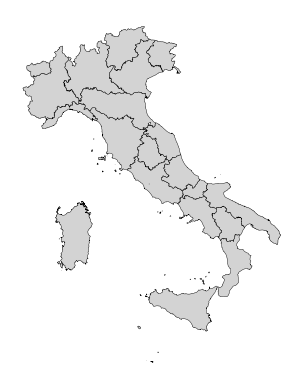

In [5]:
#Create and empty figure
fig, ax = plt.subplots()

#Define the map projection
df_gdata = df_gdata.to_crs('ESRI:53004')

#Plot the boundaries
df_gdata.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)

#Suppress all axis decorations
ax.set_axis_off()

### Generate the choroplet map

Select a sequential colourmap to encode the GDP values

In [6]:
cpalette = 'YlOrBr'

Generate the choroplet map again using [`geopandas.GeoDataFrame.plot`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html). Note that parameter `column` defines the magnitude (measure) we want to represent and `cmap` the corresponding colour encoding.

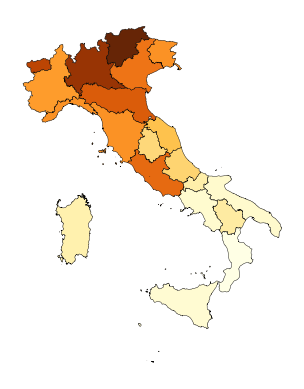

In [7]:
#Remove the previous plot
ax.clear()

#Generate the choroplet map
df_merged.plot(ax=ax, column=str(year), edgecolor='black', cmap=cpalette, linewidth=0.3)

#Suppress all axis decorations
ax.set_axis_off()

display(fig)

### Add a legend

Let's add a legend to display the colour-to-magnitude mapping. We do this in two steps: first we manually generate the entries (rectangular patches and labels) that will appear in the legend, then create the legend. There will be one entry for each of the GDP levels defined in the `levels` variable.

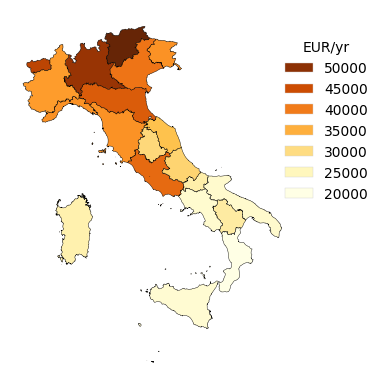

In [8]:
#Define the levels that will appear in the legend  
levels = [20000, 25000, 30000, 35000, 40000, 45000, 50000]
levels.reverse() #Swap the list to make the highest level appear at the top of the legend.

#Get the min and max GDP value for min-max normalisation (see below)
bounds = (df_merged[str(year)].min(), df_merged[str(year)].max())

#Load the colormap
cmap = mpl.colormaps[cpalette]

labels, patches = list(), list()

for level in levels:
    #Apply min-max normalisation to retrieve the corresponding colour from the colormap
    norm_value = (level - bounds[0])/(bounds[1] - bounds[0])

    #Extract the corresponding colour from the colormap
    colour = cmap(norm_value)

    #Create a rectangular patch with the given colour
    patches.append(Patch(edgecolor='lightgrey', facecolor=colour, linewidth=0.3))

    #Create the corresponding label
    labels.append(str(level))
    
#Add the legend
ax.legend(handles=patches, labels=labels, loc='upper right', bbox_to_anchor=(1.3,0.95), title='EUR/yr', frameon=False)
display(fig)

### Add title and subtitle

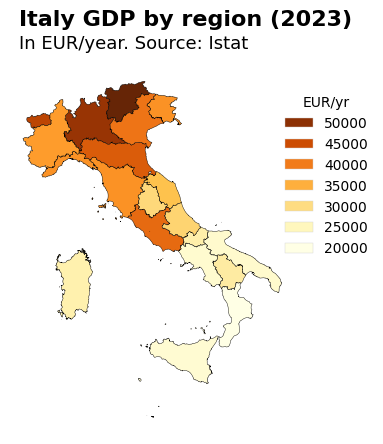

In [9]:
title = f'Italy GDP by region ({year})'
subtitle = f'In EUR/year. Source: Istat'
set_title_and_subtitle(fig=fig, title=title, subtitle=subtitle, alignment='left', h_offset=140)
display(fig)